In [1]:
%pip install streamlit pandas numpy scikit-learn matplotlib seaborn scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Music Clustering:


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.neighbors import kneighbors_graph

## 1. Data Loading & Basic EDA


In [3]:
# ------------ Load & Basic EDA ------------
df = pd.read_csv("single_genre_artists.csv")

# Quick peek
display(df.head(10))
df.info()

# Descriptive stats
display(df.describe(include='object'))
display(df.describe(exclude='object'))

# Health checks
print("Rows, Columns:", df.shape)
print('-'*45)
print("Missing values per column:")
print(df.isnull().sum())
print('-'*45)
print("Duplicate rows:", df.duplicated().sum())

# Column types overview
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)


,id_songs,name_song,popularity_songs,duration_ms,explicit,id_artists,release_date,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,genres,name_artists,popularity_artists
0,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.563,0.184,4,...,0.993,0.000016,0.3250,0.654,133.088,3,5078.0,['vintage chanson'],Mistinguett,22
1,1b8HZQCqcqwbzlA1jRTp6E,En Douce,0,223440,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.427,0.180,10,...,0.989,0.000000,0.1280,0.431,78.459,3,5078.0,['vintage chanson'],Mistinguett,22
2,5d5gQxHwYovxR5pqETOIAa,J'en Ai Marre,0,208267,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.511,0.206,0,...,0.995,0.000000,0.4180,0.481,70.443,4,5078.0,['vintage chanson'],Mistinguett,22
3,1EO65UEEPfy7CR0NK2sDxy,Ils n'ont pas ca,0,161933,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.676,0.467,9,...,0.991,0.000000,0.2190,0.726,129.775,4,5078.0,['vintage chanson'],Mistinguett,22
4,6a58gXSgqbIsXUhVZ6ZJqe,La belote,0,167973,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.650,0.298,9,...,0.991,0.000000,0.3730,0.844,75.950,4,5078.0,['vintage chanson'],Mistinguett,22
5,6sVxCBvLSd9PZA7prJn53O,Oh mademoiselle,0,158693,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.671,0.454,10,...,0.988,0.000000,0.3180,0.852,121.611,4,5078.0,['vintage chanson'],Mistinguett,22
6,3S9RAJj909UR6oOfaGxwad,Il m'a vue nue,0,196507,0,4AxgXfD7ISvJSTObqm4aIE,1925,0.515,0.249,4,...,0.994,0.000011,0.3140,0.592,72.791,4,5078.0,['vintage chanson'],Mistinguett,22
7,3vuypSGFgGT7JKJiWPJURp,Mon Bus'ness,0,172840,0,4AxgXfD7ISvJSTObqm4aIE,1925,0.415,0.330,0,...,0.978,0.000000,0.3200,0.719,72.960,4,5078.0,['vintage chanson'],Mistinguett,22
8,50gOBrK00pGazhLXGMEqwc,Ça c'est Paris,0,172987,0,4AxgXfD7ISvJSTObqm4aIE,1925,0.582,0.371,4,...,0.994,0.000647,0.0937,0.760,128.547,4,5078.0,['vintage chanson'],Mistinguett,22
9,3k4N13FLmeIcETs5zwxnvd,Le Fado,0,154733,0,4AxgXfD7ISvJSTObqm4aIE,1926,0.537,0.383,1,...,0.992,0.000004,0.1440,0.639,136.825,4,5078.0,['vintage chanson'],Mistinguett,22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95837 entries, 0 to 95836
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_songs            95837 non-null  object 
 1   name_song           95837 non-null  object 
 2   popularity_songs    95837 non-null  int64  
 3   duration_ms         95837 non-null  int64  
 4   explicit            95837 non-null  int64  
 5   id_artists          95837 non-null  object 
 6   release_date        95837 non-null  object 
 7   danceability        95837 non-null  float64
 8   energy              95837 non-null  float64
 9   key                 95837 non-null  int64  
 10  loudness            95837 non-null  float64
 11  mode                95837 non-null  int64  
 12  speechiness         95837 non-null  float64
 13  acousticness        95837 non-null  float64
 14  instrumentalness    95837 non-null  float64
 15  liveness            95837 non-null  float64
 16  vale

,id_songs,name_song,id_artists,release_date,genres,name_artists
count,95837,95837,95837,95837,95837,95837
unique,95837,85427,18009,10436,3153,17662
top,0IA0Hju8CAgYfV1hwhidBH,Bibi Blocksberg Lied,3meJIgRw7YleJrmbpbJK6S,1983,['hoerspiel'],Die drei ???
freq,1,33,3856,754,8027,3856


,popularity_songs,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artists
count,95837.000000,9.583700e+04,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,95837.000000,9.583700e+04,95837.000000
mean,26.066394,2.087320e+05,0.029644,0.586853,0.541083,5.196782,-10.157862,0.648069,0.168832,0.458989,0.082145,0.224916,0.574281,117.539870,3.851362,1.979919e+05,42.819329
std,16.254133,1.177526e+05,0.169604,0.155422,0.236304,3.534923,4.748798,0.477575,0.275417,0.330416,0.232440,0.185829,0.248126,30.190399,0.544406,7.807520e+05,20.897833
min,0.000000,6.373000e+03,0.000000,0.000000,0.000020,0.000000,-50.174000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,13.000000,1.573330e+05,0.000000,0.488000,0.365000,2.000000,-12.723000,0.000000,0.034100,0.133000,0.000000,0.100000,0.378000,94.829000,4.000000,2.563000e+03,28.000000
50%,26.000000,2.040000e+05,0.000000,0.605000,0.542000,5.000000,-9.397000,1.000000,0.046200,0.453000,0.000004,0.149000,0.589000,116.595000,4.000000,1.595600e+04,40.000000
75%,37.000000,2.502670e+05,0.000000,0.700000,0.727000,8.000000,-6.692000,1.000000,0.103000,0.759000,0.001300,0.302000,0.780000,135.975000,4.000000,8.495100e+04,56.000000
max,98.000000,4.800118e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.968000,0.996000,1.000000,0.997000,1.000000,239.906000,5.000000,2.802643e+07,95.000000


Rows, Columns: (95837, 23)
---------------------------------------------
Missing values per column:
id_songs              0
name_song             0
popularity_songs      0
duration_ms           0
explicit              0
id_artists            0
release_date          0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
time_signature        0
followers             0
genres                0
name_artists          0
popularity_artists    0
dtype: int64
---------------------------------------------
Duplicate rows: 0
Numeric: ['popularity_songs', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'followers', 'popularity_artists']
Categorical: ['id_songs',

## 2. Feature Selection

- Drop non-modeling identifiers
- Keep core audio features


In [4]:
# --- Drop non-modeling identifiers ---
df = df.drop(['id_songs', 'name_song', 'name_artists', 'id_artists'], axis=1)


features = [
    'danceability','energy','loudness','speechiness',
    'acousticness','instrumentalness','liveness',
    'valence','tempo','duration_ms'
]

df_clean = df[features].copy()
display(df_clean.head())


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.563,0.184,-13.757,0.0512,0.993,0.000016,0.325,0.654,133.088,161427
1,0.427,0.180,-15.375,0.0670,0.989,0.000000,0.128,0.431,78.459,223440
2,0.511,0.206,-15.514,0.0592,0.995,0.000000,0.418,0.481,70.443,208267
3,0.676,0.467,-12.393,0.1650,0.991,0.000000,0.219,0.726,129.775,161933
4,0.650,0.298,-13.806,0.1380,0.991,0.000000,0.373,0.844,75.950,167973


## 3. Distributions (EDA)

- Inspect feature distributions


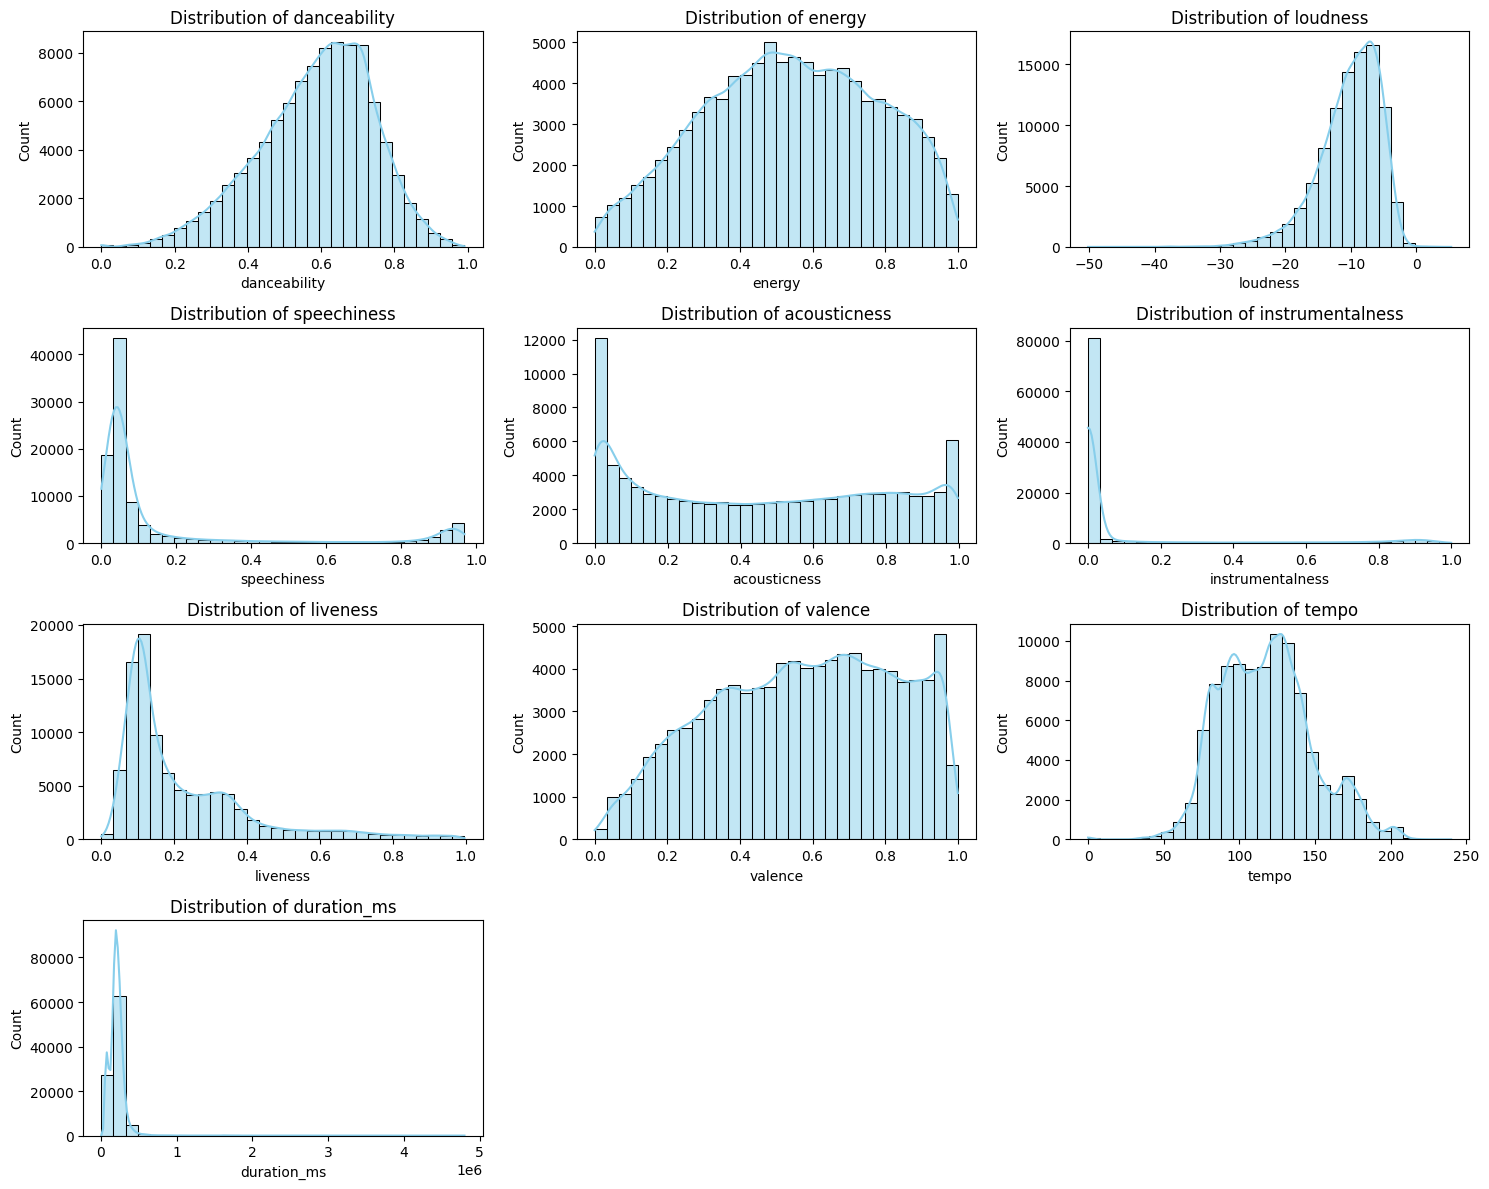

In [5]:
# --- Distributions (EDA) ---
plt.figure(figsize=(15, 12))
for i, col in enumerate(df_clean.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df_clean[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

## 4. Scaling

- Standardize features


In [6]:
# --- Scale features ---
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_clean)
df_scaled = pd.DataFrame(scaled_array, columns=df_clean.columns)
display(df_scaled.head())

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,-0.153476,-1.511128,-0.757909,-0.427109,1.616187,-0.353338,0.538584,0.321287,0.515005,-0.401735
1,-1.028518,-1.528056,-1.098629,-0.369741,1.604081,-0.353405,-0.521537,-0.577455,-1.294487,0.124906
2,-0.488051,-1.418027,-1.127899,-0.398062,1.622240,-0.353405,1.039046,-0.375943,-1.560003,-0.003949
3,0.573581,-0.313510,-0.470677,-0.013914,1.610134,-0.353405,-0.031836,0.611464,0.405268,-0.397437
4,0.406294,-1.028695,-0.768227,-0.111948,1.610134,-0.353405,0.796887,1.087031,-1.377593,-0.346143


## 5. Reusable Plotting Helpers

- Encapsulate PCA scatter, cluster profiles, and boxplots


In [7]:
# ====== Reusable plotting helpers ======


def plot_pca_clusters(X_scaled: pd.DataFrame,
                      labels: pd.Series | np.ndarray,
                      title_prefix: str = "",
                      sample_max: int = 20000,
                      hue_name: str = "cluster"):
    """
    Fit PCA(2) on X_scaled (no label leakage), then scatter color by labels.
    X_scaled: dataframe of scaled features ONLY (no label columns)
    labels: array-like cluster labels aligned to X_scaled.index
    """
    # Fit PCA on pure features
    pca = PCA(n_components=2, random_state=42)
    pts = pca.fit_transform(X_scaled)

    # Build plotting frame
    pca_df = pd.DataFrame(pts, columns=['PC1','PC2'], index=X_scaled.index)
    pca_df[hue_name] = np.array(labels)

    # Sampling (cap for speed)
    if len(pca_df) > sample_max:
        pca_df = pca_df.sample(sample_max, random_state=42)

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=hue_name,
                    palette='tab10', s=12, alpha=0.6, legend='full')
    title = f"PCA projection — {title_prefix}".strip()
    plt.title(title)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% var)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% var)')
    plt.legend(title=hue_name, bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_cluster_profile_bar(cluster_profile: pd.DataFrame,
                             title: str = "Average Audio Feature Values per Cluster",
                             legend_title: str = "Cluster"):
    """Bar chart of feature means per cluster."""
    ax = cluster_profile.T.plot(kind='bar', figsize=(12,6))
    plt.title(title)
    plt.xlabel('Audio Features'); plt.ylabel('Mean Value')
    plt.legend(title=legend_title, bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout(); plt.show()


def plot_cluster_profile_heat(cluster_profile: pd.DataFrame,
                              title: str = "Heatmap of Audio Features Across Clusters",
                              xlabel: str = "Audio Features",
                              ylabel: str = "Cluster"):
    """Heatmap of feature means per cluster."""
    plt.figure(figsize=(8,5))
    sns.heatmap(cluster_profile, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout(); plt.show()


def plot_feature_boxplots(df_with_labels: pd.DataFrame,
                          label_col: str,
                          features: list[str],
                          title_prefix: str = "Distribution of"):
    """Boxplots of selected features split by label_col."""
    for col in features:
        plt.figure(figsize=(6,5))
        sns.boxplot(x=label_col, y=col, data=df_with_labels,
                    palette='tab10', hue=label_col, legend=False)
        plt.title(f'{title_prefix} {col.capitalize()} Across Clusters')
        plt.xlabel('Cluster'); plt.ylabel(col.capitalize())
        plt.tight_layout(); plt.show()


def compute_cluster_profile(df_with_labels: pd.DataFrame,
                            features: list[str],
                            label_col: str) -> pd.DataFrame:
    """Mean profile table per cluster."""
    return df_with_labels.groupby(label_col)[features].mean().round(3)


## 6. K Selection (K-Means)

- Plot **Elbow (SSE)** and **Silhouette**
- Select **BEST_K**


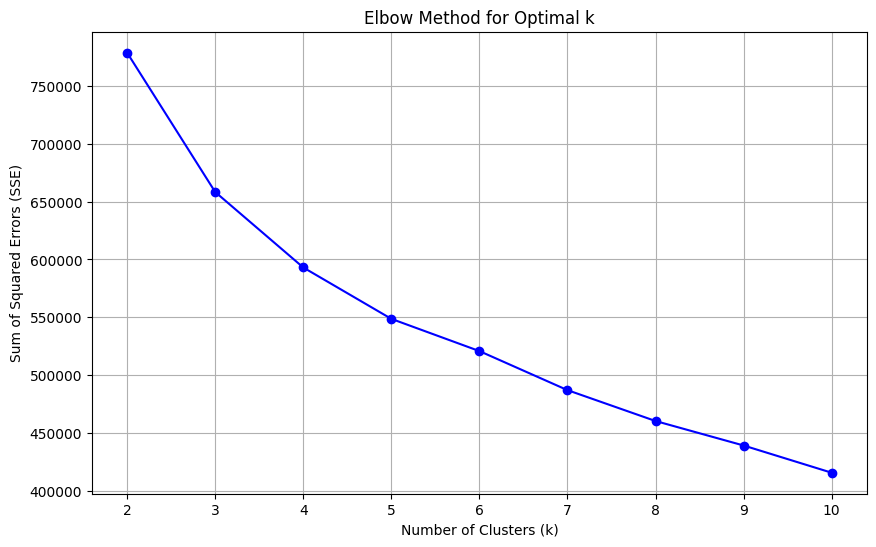

In [8]:
sse = []  # Sum of Squared Errors
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

k=2: Silhouette Score = 0.203
k=3: Silhouette Score = 0.242
k=4: Silhouette Score = 0.231
k=5: Silhouette Score = 0.186
k=6: Silhouette Score = 0.159
k=7: Silhouette Score = 0.188
k=8: Silhouette Score = 0.168
k=9: Silhouette Score = 0.167
k=10: Silhouette Score = 0.174


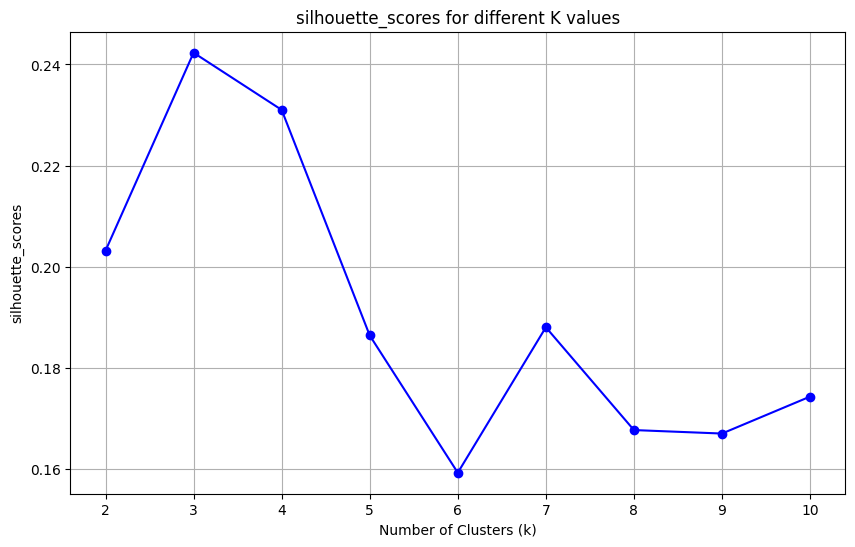

In [9]:
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: Silhouette Score = {silhouette_avg:.3f}")
    
# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('silhouette_scores')
plt.title('silhouette_scores for different K values')
plt.xticks(k_range)
plt.grid(True)
plt.show()


## 7. K-Means Clustering

- Fit K-Means with `BEST_K`
- Evaluate **Silhouette** and **Davies-Bouldin**
- Compute **cluster profiles** (feature means)


In [10]:
BEST_K = 3

kmeans = KMeans(n_clusters=BEST_K, random_state=42, n_init=10, algorithm='elkan')
labels = kmeans.fit_predict(df_scaled)


df_scaled['cluster'] = labels
df_result = df.copy()
df_result['cluster'] = labels

print("Cluster counts:\n", df_scaled['cluster'].value_counts().sort_index())

# --- Evaluate and interpret ---
X = df_scaled.drop(columns=['cluster'])
sil = silhouette_score(X, df_scaled['cluster'])
dbi = davies_bouldin_score(X, df_scaled['cluster'])
print(f"Silhouette Score: {sil:.3f}")
print(f"Davies-Bouldin Index: {dbi:.3f}")

# Feature means per cluster
cluster_profile_kmeans = df_result.groupby('cluster')[features].mean().round(3)
display(cluster_profile_kmeans)


Cluster counts:
 cluster
0    12513
1    30807
2    52517
Name: count, dtype: int64
Silhouette Score: 0.242
Davies-Bouldin Index: 1.570


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
cluster,,,,,,,,,,
0,0.664,0.467,-13.364,0.830,0.586,0.001,0.436,0.584,100.389,97520.590
1,0.486,0.311,-13.205,0.060,0.749,0.169,0.182,0.413,111.940,223457.064
2,0.627,0.694,-7.606,0.075,0.258,0.051,0.200,0.666,124.911,226592.053


## 8. K-Means Visualizations

- **PCA 2D**
- **Profiles**: bar chart + heat “map” of means
- **Boxplots** for key features across clusters


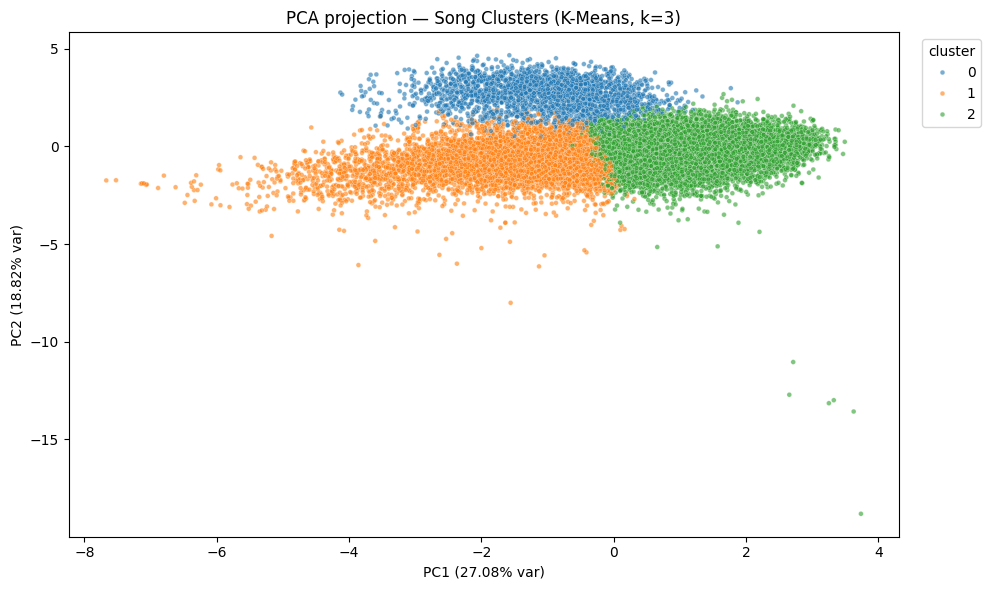

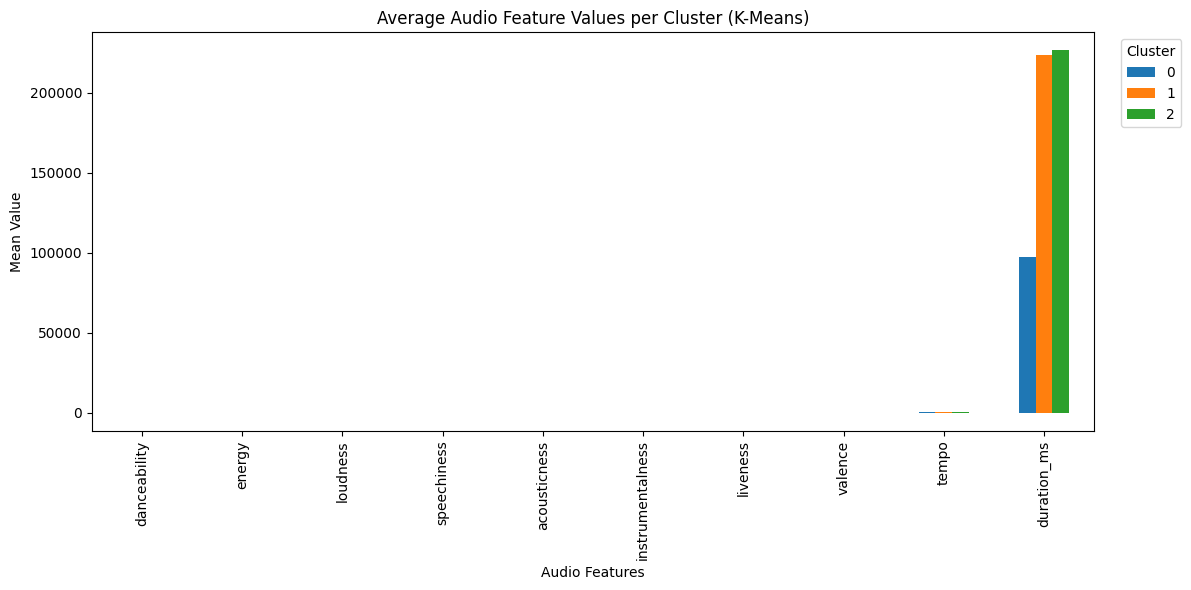

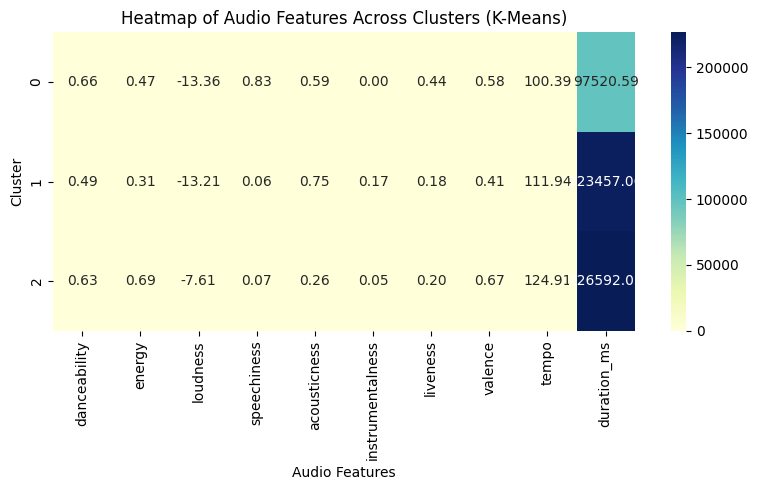

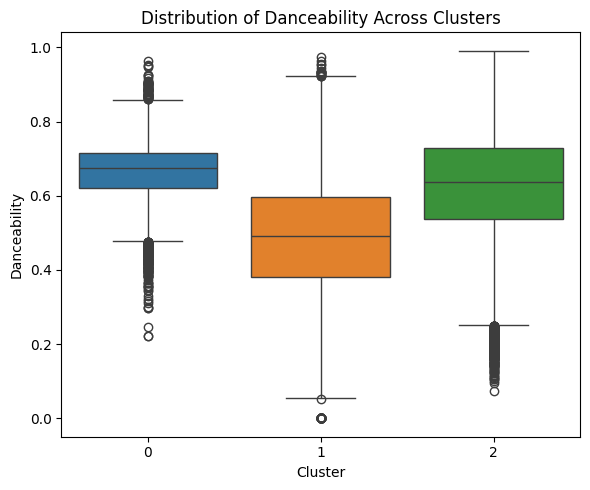

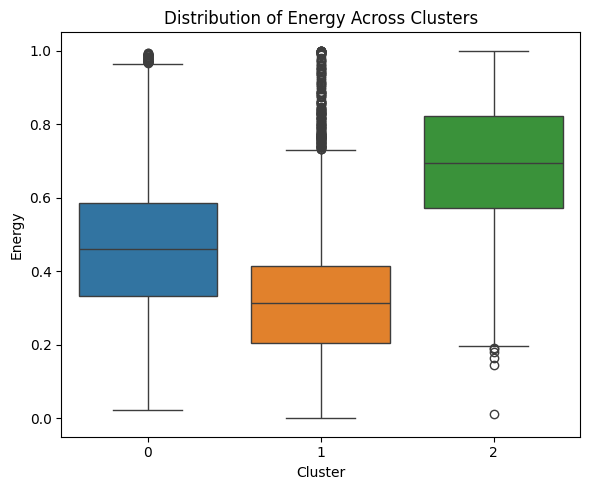

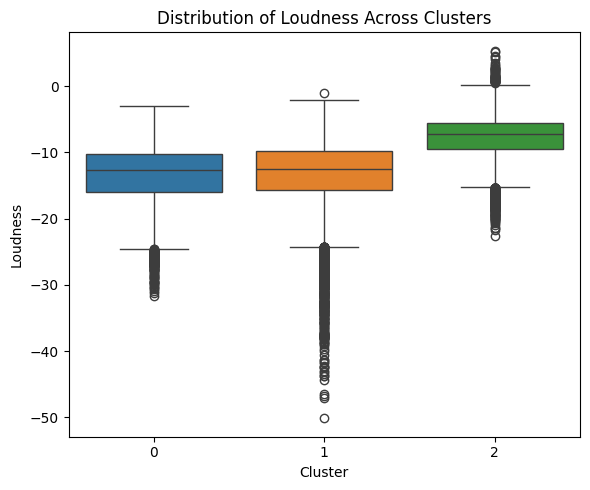

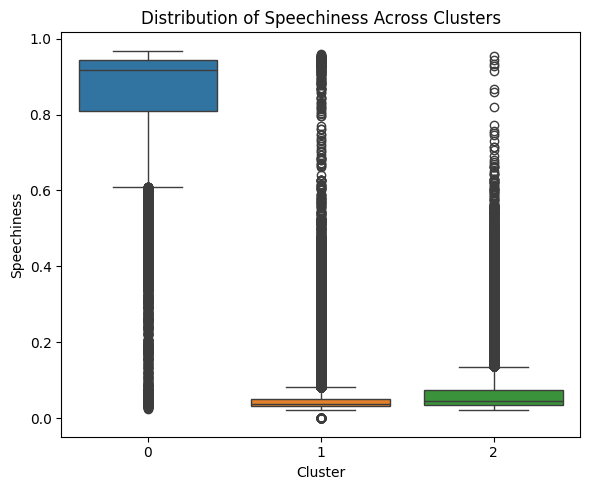

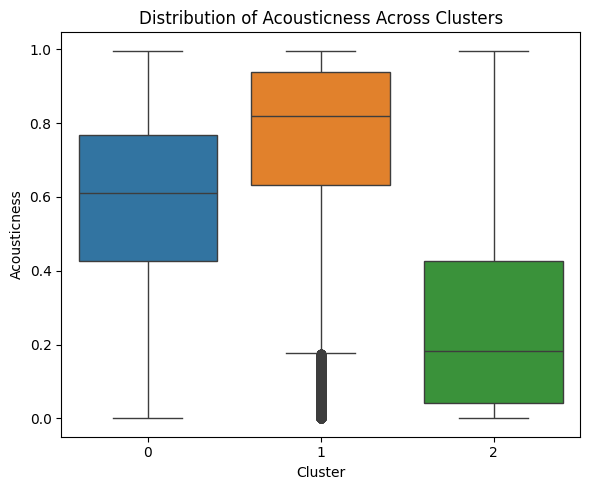

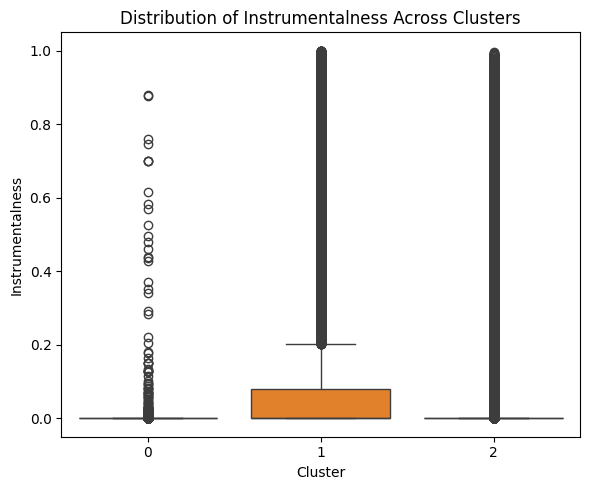

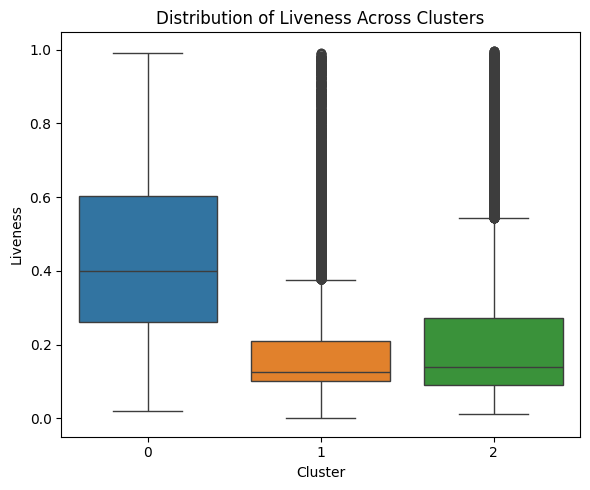

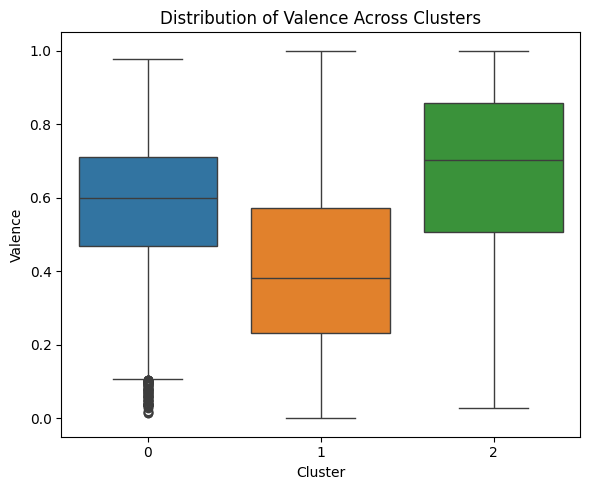

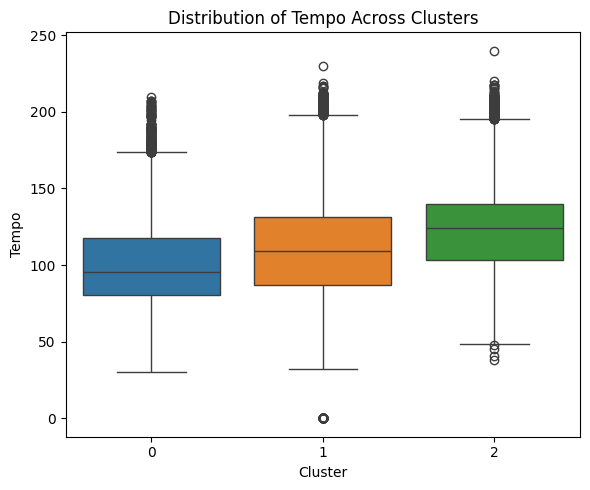

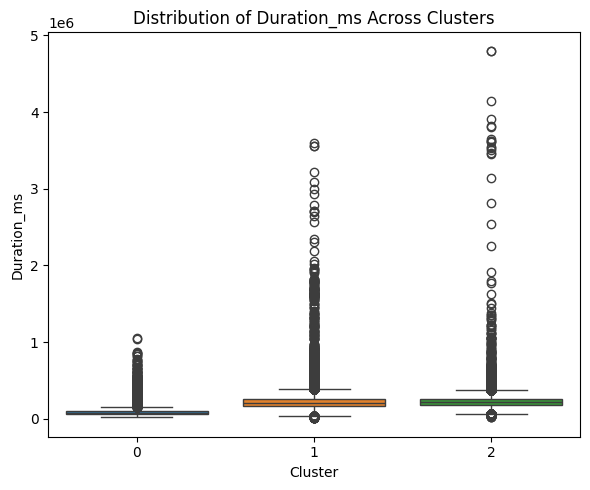

In [11]:
# Make sure X here is JUST features (no 'cluster' column!)
X_no_labels = df_scaled.drop(columns=['cluster'], errors='ignore')

# PCA scatter
plot_pca_clusters(
    X_scaled=X_no_labels,
    labels=df_scaled['cluster'],
    title_prefix=f"Song Clusters (K-Means, k={BEST_K})",
    hue_name="cluster"
)

# Profiles
cluster_profile_kmeans = compute_cluster_profile(df_result, features, label_col='cluster')

# Bar + Heat
plot_cluster_profile_bar(cluster_profile_kmeans,
                         title='Average Audio Feature Values per Cluster (K-Means)',
                         legend_title='Cluster')
plot_cluster_profile_heat(cluster_profile_kmeans,
                          title='Heatmap of Audio Features Across Clusters (K-Means)')

# Boxplots
plot_feature_boxplots(df_result, label_col='cluster',
                      features=['danceability','energy','loudness','speechiness', 'acousticness','instrumentalness','liveness','valence','tempo','duration_ms'])


## 9. Export: Labeled CSV (K-Means)

- Save clustered_songs_kmeans csv


In [12]:
# === Export: K-Means labeled dataset ===

df_kmeans = df.copy()
df_kmeans['kmeans_cluster'] = df_scaled['cluster'].values   

kmeans_csv_path = f"clustered_songs_kmeans_k{BEST_K}.csv"
df_kmeans.to_csv(kmeans_csv_path, index=False)
print("Saved:", kmeans_csv_path)
print("Shape:", df_kmeans.shape)
df_kmeans.head(10)


Saved: clustered_songs_kmeans_k3.csv
Shape: (95837, 20)


,popularity_songs,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,genres,popularity_artists,kmeans_cluster
0,0,161427,0,1922,0.563,0.184,4,-13.757,1,0.0512,0.993,0.000016,0.3250,0.654,133.088,3,5078.0,['vintage chanson'],22,1
1,0,223440,0,1922,0.427,0.180,10,-15.375,1,0.0670,0.989,0.000000,0.1280,0.431,78.459,3,5078.0,['vintage chanson'],22,1
2,0,208267,0,1922,0.511,0.206,0,-15.514,1,0.0592,0.995,0.000000,0.4180,0.481,70.443,4,5078.0,['vintage chanson'],22,1
3,0,161933,0,1924,0.676,0.467,9,-12.393,0,0.1650,0.991,0.000000,0.2190,0.726,129.775,4,5078.0,['vintage chanson'],22,1
4,0,167973,0,1924,0.650,0.298,9,-13.806,1,0.1380,0.991,0.000000,0.3730,0.844,75.950,4,5078.0,['vintage chanson'],22,1
5,0,158693,0,1924,0.671,0.454,10,-14.390,1,0.2790,0.988,0.000000,0.3180,0.852,121.611,4,5078.0,['vintage chanson'],22,1
6,0,196507,0,1925,0.515,0.249,4,-9.382,1,0.0408,0.994,0.000011,0.3140,0.592,72.791,4,5078.0,['vintage chanson'],22,1
7,0,172840,0,1925,0.415,0.330,0,-14.533,1,0.1280,0.978,0.000000,0.3200,0.719,72.960,4,5078.0,['vintage chanson'],22,1
8,0,172987,0,1925,0.582,0.371,4,-9.032,1,0.0337,0.994,0.000647,0.0937,0.760,128.547,4,5078.0,['vintage chanson'],22,1
9,0,154733,0,1926,0.537,0.383,1,-12.114,1,0.0567,0.992,0.000004,0.1440,0.639,136.825,4,5078.0,['vintage chanson'],22,1


In [13]:
# === FINAL ANALYSIS AND EXPORT ===

df_final = df.copy()

if 'cluster' in df_scaled.columns:
    df_final['kmeans_cluster'] = df_scaled['cluster']


# Sort/group by clusters
if 'name_song' in df.columns or 'name_artists' in df.columns:
    group_col = 'name_song' if 'name_song' in df.columns else 'name_artists'
    print("Top 3 items per K-Means cluster:\n")
    # first 3 rows per cluster with that name column 
    top3 = (df_final[[group_col, 'kmeans_cluster']]
            .groupby('kmeans_cluster', group_keys=False)
            .apply(lambda g: g.head(3)))
    display(top3)
else:
    print("No name column available — showing numeric preview only.\n")
    numeric_cols = df_final.select_dtypes(include=[np.number]).columns
    preview = (df_final.groupby('kmeans_cluster')[numeric_cols].mean()) 
    display(preview.head())

# Export final combined dataset
final_csv_path = "clustered_songs_final_combined.csv"
df_final.to_csv(final_csv_path, index=False)
print(f"Final dataset exported to: {final_csv_path}")

feat_cols = [c for c in features if c in df_final.columns]
cluster_summary = (df_final
                   .groupby('kmeans_cluster')[feat_cols]
                   .mean()     
                   .round(2))
print("\nCluster Feature Averages (K-Means):")
display(cluster_summary)



No name column available — showing numeric preview only.



,popularity_songs,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artists,kmeans_cluster
kmeans_cluster,,,,,,,,,,,,,,,,,,
0,28.166547,97520.590026,0.006074,0.664271,0.466636,5.026772,-13.363885,0.654839,0.829978,0.585932,0.001385,0.435535,0.584036,100.389473,3.585231,214470.729481,70.016703,0.0
1,20.708475,223457.063979,0.006103,0.486381,0.311231,5.135132,-13.205013,0.674782,0.060140,0.749228,0.168547,0.182070,0.413254,111.939598,3.793131,149941.774824,35.310124,1.0
2,28.709009,226592.052516,0.049070,0.627345,0.693655,5.273454,-7.606487,0.630786,0.075064,0.258485,0.050703,0.199867,0.666416,124.911397,3.948931,222252.333244,40.744102,2.0


Final dataset exported to: clustered_songs_final_combined.csv

Cluster Feature Averages (K-Means):


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
kmeans_cluster,,,,,,,,,,
0,0.66,0.47,-13.36,0.83,0.59,0.00,0.44,0.58,100.39,97520.59
1,0.49,0.31,-13.21,0.06,0.75,0.17,0.18,0.41,111.94,223457.06
2,0.63,0.69,-7.61,0.08,0.26,0.05,0.20,0.67,124.91,226592.05
